In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the neural network
class ODENet(tf.keras.Model):
    def __init__(self):
        super(ODENet, self).__init__()
        self.dense1 = tf.keras.layers.Dense(100, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.dense2 = tf.keras.layers.Dense(100, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.dense3 = tf.keras.layers.Dense(1, activation='linear')

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)

model = ODENet()

# Central difference for second derivative
def second_derivative(y, h=0.01):
    d2y = (y[2:] - 2*y[1:-1] + y[:-2]) / h**2
    return d2y

# Loss function
def loss_fn(model, x, f, h=0.01):
    with tf.GradientTape(persistent=True) as tape2:
        with tf.GradientTape(persistent=True) as tape1:
            tape2.watch(x)
            tape1.watch(x)
            y_pred = model(x)
        dy_dx = tape1.gradient(y_pred, x)
    d2y_dx2 = tape2.gradient(dy_dx, x)

    # Residual from the differential equation
    residual = (d2y_dx2 - f(x)) / h

    # Calculate the loss as the squared error
    loss = tf.reduce_mean(tf.square(residual))
    
    # Add boundary conditions to the loss
    loss += 0.5 * tf.square(model(tf.constant([[0.0]], dtype=tf.float32)))
    loss += 0.5 * tf.square(model(tf.constant([[1.0]], dtype=tf.float32)))
    
    return loss


# Define the optimizer
optimizer = tf.keras.optimizers.legacy.Adamax(learning_rate=0.001)

# Train the model
def train_step(model, x, f, h=0.01):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, x, f, h)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

# Define f(x)
def f(x):
    return model(x)

# Define the analytical solution
def analytical_solution(t):
    return (-np.exp(1)/(-np.exp(2)+1)*np.exp(t) + np.exp(1)/(-np.exp(2)+1)*np.exp(-t))



# Boundary conditions
y0 = tf.constant([[0.0]], dtype=tf.float32)
y1 = tf.constant([[1.0]], dtype=tf.float32)

# Train the model


Step: 0, Loss: [[12556.479]]
Step: 1000, Loss: [[0.00238279]]
Step: 2000, Loss: [[0.00147718]]
Step: 3000, Loss: [[0.00116269]]
Step: 4000, Loss: [[0.00096587]]
Step: 5000, Loss: [[0.00298571]]
Step: 6000, Loss: [[0.00059307]]
Step: 7000, Loss: [[0.2572193]]
Step: 8000, Loss: [[0.01480012]]
Step: 9000, Loss: [[0.1313241]]
Step: 10000, Loss: [[0.00020832]]
Step: 11000, Loss: [[0.00016794]]
Step: 12000, Loss: [[0.00013771]]
Step: 13000, Loss: [[0.00012246]]
Step: 14000, Loss: [[0.00025883]]
Step: 15000, Loss: [[0.00046194]]
Step: 16000, Loss: [[0.00010296]]
Step: 17000, Loss: [[9.779638e-05]]
Step: 18000, Loss: [[9.375114e-05]]
Step: 19000, Loss: [[9.126593e-05]]
32/32 [==============================] - 0s 407us/step


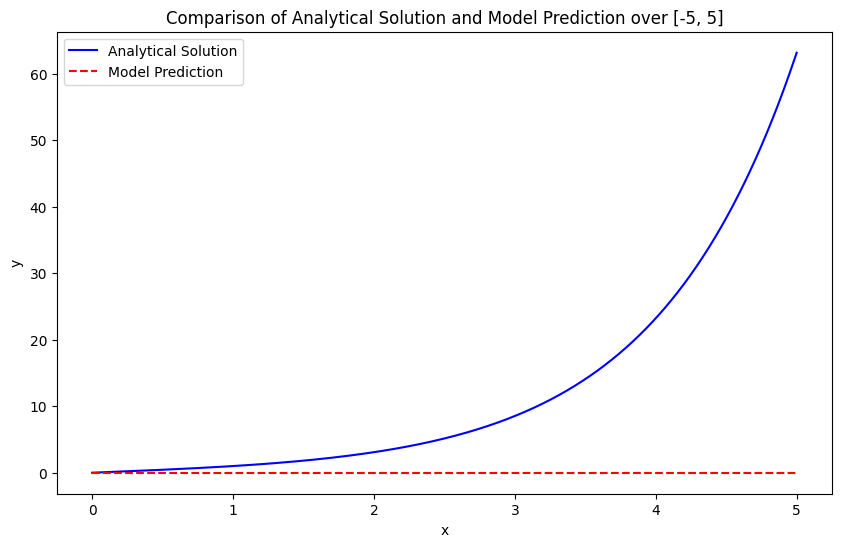

In [2]:

x_samples_dense = np.linspace(2, 5, 500)  # Denser samples in the region [0,1]
x_samples_wide = np.linspace(0, 5, 500)  # Wider range
x_samples = np.sort(np.concatenate((x_samples_dense, x_samples_wide)))  # Combine and sort
x_samples = tf.convert_to_tensor(x_samples.reshape(-1, 1), dtype=tf.float32)

for step in range(20000):
    loss = train_step(model, x_samples, f)
    if step % 1000 == 0:
        print(f"Step: {step}, Loss: {loss.numpy()}")

# Visualization over the range [-5, 5]
x_test = np.linspace(0, 5, 1000).reshape(-1, 1)
y_true = analytical_solution(x_test)
y_pred = model.predict(x_test)

plt.figure(figsize=(10, 6))
plt.plot(x_test, y_true, label='Analytical Solution', color='blue')
plt.plot(x_test, y_pred, label='Model Prediction', color='red', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison of Analytical Solution and Model Prediction over [-5, 5]')
plt.show()
#y'' = y , y(0)=0, y(1)=1
